In [74]:
import pandas as pd
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import re
from string import punctuation
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
from collections import defaultdict
from nltk.corpus import wordnet as wn
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib

<p style="font-family:Muro;font-weight:bold;font-size:35px;margin:10px 0px 10px 0px;color:#ADD8E6">Wordclouds</p>

## On the dialogue

In [2]:
script_path = "Data/the-office-lines-script.xlsx"
df_dialog = pd.read_excel(script_path, index_col = "id")

In [3]:
# We remove the parenthetical. That is, the text into parenthesis that provides directions for the characters.
parentheticals_regex = r"(\[.*?\])"

def remove_parentheticals(line):
    line = str(line)
    parentheticals = re.findall(parentheticals_regex,line)
    
    for parenthetical in parentheticals:
        line = line.replace(parenthetical, "")
    
    return line

In [4]:
def get_character_lines_per_episode(character, remove_par = True):

    df_aired_lines = df_dialog.loc[df_dialog.deleted == False]
    df_character = df_aired_lines.loc[df_aired_lines.speaker == character]
    
    character_season_lines = {}

    for season in df_character.season.unique():
        df_season = df_character.loc[df_character.season == season]
        character_episode_lines = {}
        
        for episode in df_season.episode.unique():
            df_episode = df_season.loc[df_season.episode == episode]           
            character_episode_lines[episode] = list(df_episode.line_text)
            
            if remove_par:
                character_episode_lines[episode] = [remove_parentheticals(line) for line in list(df_episode.line_text)]
        
        character_season_lines[season] = character_episode_lines
        
    return character_season_lines

In [5]:
def get_character_lines_per_season(character):
    character_season_lines = get_character_lines_per_episode(character)       
    return {season:[line for episode in episodes.values() for line in episode] for (season, episodes) in character_season_lines.items()}

In [6]:
def get_character_lines_series(character):  
    dialog = get_character_lines_per_season(character)
    return [line for season in dialog.values() for line in season]

In [7]:
def un_pack_episode_lines(character):
    episode_lines = get_character_lines_per_episode(character)   
    return [lines for episode in episode_lines.values() for lines in episode.values()]

In [8]:
sw = stopwords.words('english')
tk = nltk.WordPunctTokenizer()

def tokenize_text(text):
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', punctuation.replace("'","")))
    
    #Generating the tokens
    tokens = tk.tokenize(text)
    
    #Removing all the stopwords
    new_tokens = [token.lower() for token in tokens if token not in stopwords.words('english')]
    
    #Generating the lemmatizer and returning the output
    wnl = nltk.WordNetLemmatizer()
    output = [wnl.lemmatize(t) for t in new_tokens]
    
    return output

def tokenize_sentences(sentences):
    return tokenize_text(" ".join(sentences))

In [9]:
def tc(token_list):
    tc = {}
    tokens = [word for tokens in token_list for word in tokens]
    for key, value in nltk.FreqDist(tokens).items():
        tc[key] = value
    return tc

def idf(texts):
    text = nltk.TextCollection(texts)
    idf = {}
    for word in text:
        idf[word] = text.idf(word)
    return idf

def idf_log(token_list):
    unique_tokens = np.unique([word for tokens in token_list for word in tokens])
    idf = {}
    n_documents = len(token_list)
        
    for word in unique_tokens:
        n_documents_with_word = [1 for document in token_list if word in document]
        idf[word] = np.log((n_documents)/(len(n_documents_with_word)+1))
        
    return idf

def tc_logidf(tokens):
    tc_ = tc(tokens)
    idf_log_ = idf_log(tokens)  
    return {word:tc_[word]*math.ceil(idf_log_[word]) for word in tc_.keys()}
        
def tc_idf(tokens):
    tc_ = tc(tokens)
    idfs = idf(tokens)
    tc_idf = {}
    tokens = [word for token_list in tokens for word in token_list]
    for word in tokens:
        tc_idf[word] = int(math.ceil(idfs[word])) * tc_[word]
    return tc_idf

In [10]:
characters_to_analyze = ["Michael", "Jim", "Dwight", "Pam", "Andy"]
characters_tokens = {}

for character in characters_to_analyze:
    texts = un_pack_episode_lines(character)
    tokens = [tokenize_sentences(text) for text in texts]
    
    characters_tokens[character] = tokens

In [11]:
from PIL import Image
link_mask = np.array(Image.open("jim.jpg"))

def make_wordcloud_image(character):
    
    tc_idfs = tc_idf(characters_tokens[character])    
    words_by_weight = [[word]*weight for (word, weight) in tc_idfs.items()]
    output = " ".join([word for lst in words_by_weight for word in lst])

    wordcloud = WordCloud(max_words=250, background_color="white", collocations=False, mask = link_mask, contour_width=3, contour_color='black').generate(output)
    plt.figure(figsize=[20,10])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    #plt.figtext(0.5, 0, f"Figure; {character.capitalize()}; WordCloud", wrap=True, horizontalalignment='center', fontsize=20)
    plt.show()

In [12]:
def get_toke_text_dialog(character):
    tc_idfs = tc_idf(characters_tokens[character])    
    words_by_weight = [[word]*weight for (word, weight) in tc_idfs.items() if "v" not in [t.pos() for t in wn.synsets(word)] and word not in common_words]
    return " ".join([word for lst in words_by_weight for word in lst])

In [13]:
common_words = ["oh", "yeah", "ok", "im", "dont", "hey", "youre", "thats"]
common_words = []

def make_wordcloud(output, character):
      
    wordcloud = WordCloud(max_words=150, background_color="white", collocations=False, contour_width=3, contour_color='black').generate(output)       
    plt.figure(figsize=[10,5])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Wordcloud for {character}")
    plt.show()

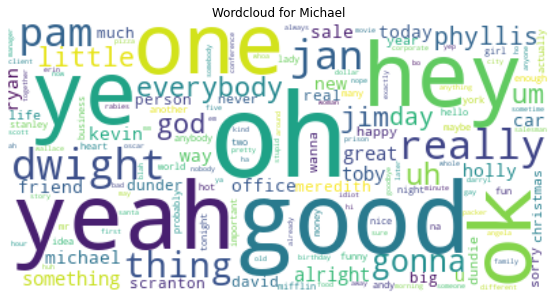

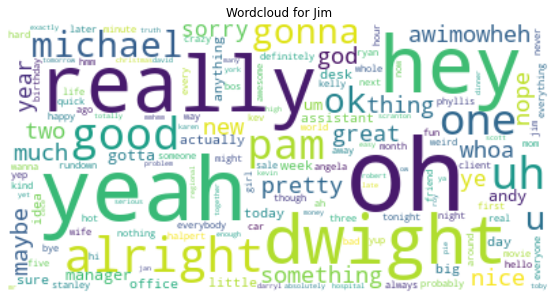

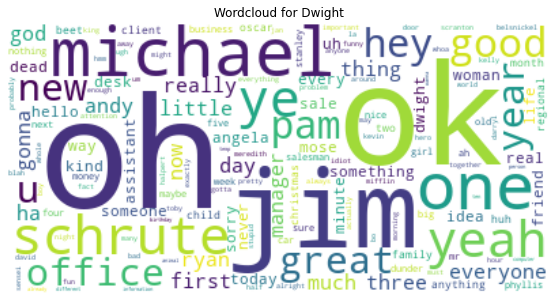

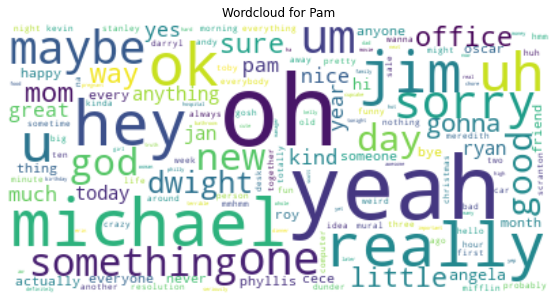

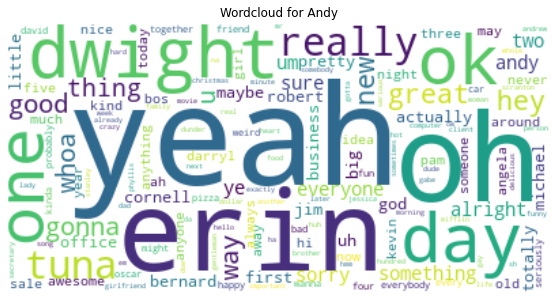

In [14]:
for character in characters_to_analyze:
    output = get_toke_text_dialog(character)
    make_wordcloud(output,character)

## On the wiki pages

In [15]:
G = nx.readwrite.adjlist.read_adjlist("Data/GCC.gz")
surnames_and_names = "_".join(G.nodes()).split("_")
words_to_remove = ["episode", "season", "character", "carell", "wilson", "jenna", "fischer", "series", "tv", "u", "usnbs", "angeles", "los"] + [c.lower() for c in surnames_and_names]

In [16]:
def get_token_text_wiki_page(character):
    f = open(f"characters/{character}.txt", encoding="utf8")
    text = f.read() 
    text = text[:text.index("Appearances")]
    tokens = [token for token in tokenize_text(text) if all([w not in token for w in words_to_remove])]
    return " ".join(tokens) 

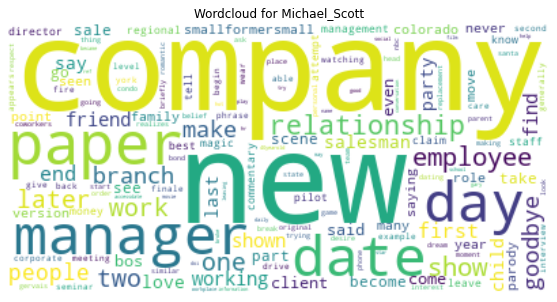

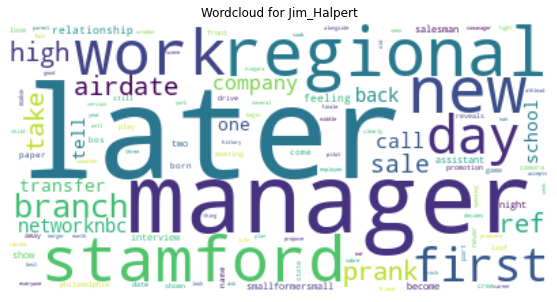

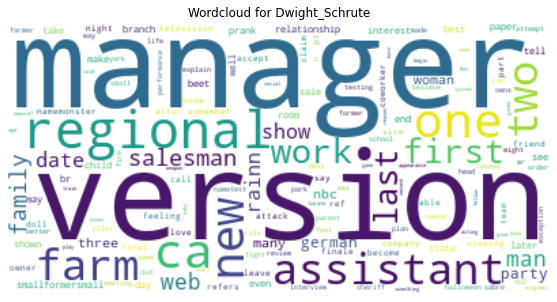

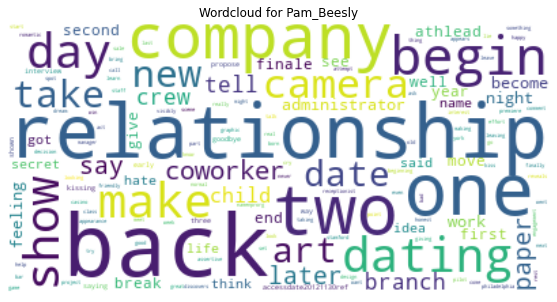

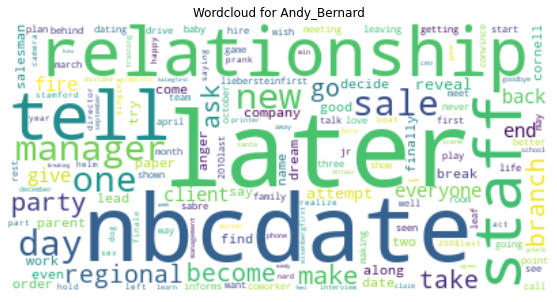

In [17]:
characters_to_analyze = ["Michael_Scott", "Jim_Halpert", "Dwight_Schrute", "Pam_Beesly", "Andy_Bernard"]

for character in characters_to_analyze:
    output = get_token_text_wiki_page(character)  

    wordcloud = WordCloud(max_words=150, background_color="white", collocations=False, contour_width=3, contour_color='black').generate(output)    
    
    make_wordcloud(output,character)

In [54]:
characters_all = ["Michael", "Jim", "Pam", "Dwight", "Angela", "Oscar", "Kevin", "Andy", "Erin", "Phyllis", "Darryl",
                 "Stanley", "Toby", "Kelly", "Ryan"]
character_lines_all = {}

for character in characters_all:
    episode_lines = get_character_lines_per_episode(character, remove_par = False)
    character_lines_all[character] = "".join(str(lines) for episode in episode_lines.values() for lines in episode.values())

In [55]:
from collections import Counter
character_relations = {}
char_lower = [c.lower() for c in characters_all]

for character in characters_all: 
    text = character_lines_all[character]
    text = [token for token in tokenize_text(text) if token in char_lower]
    counter = Counter(text)
    relations = {}      
    character_relations[character.lower()] = dict(counter)

In [59]:
with open('Data/interaction_dict.pickle', 'wb') as handle:
    pickle.dump(character_relations, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [80]:
def capitalize(w):
    return w[0].upper() + w[1:]

In [82]:
G = nx.Graph()
#G.add_nodes_from(character_relations.keys())
G.add_edges_from([(capitalize(char),capitalize(link), {'Weight': weight}) for (char,val) in character_relations.items() for (link,weight) in val.items()])

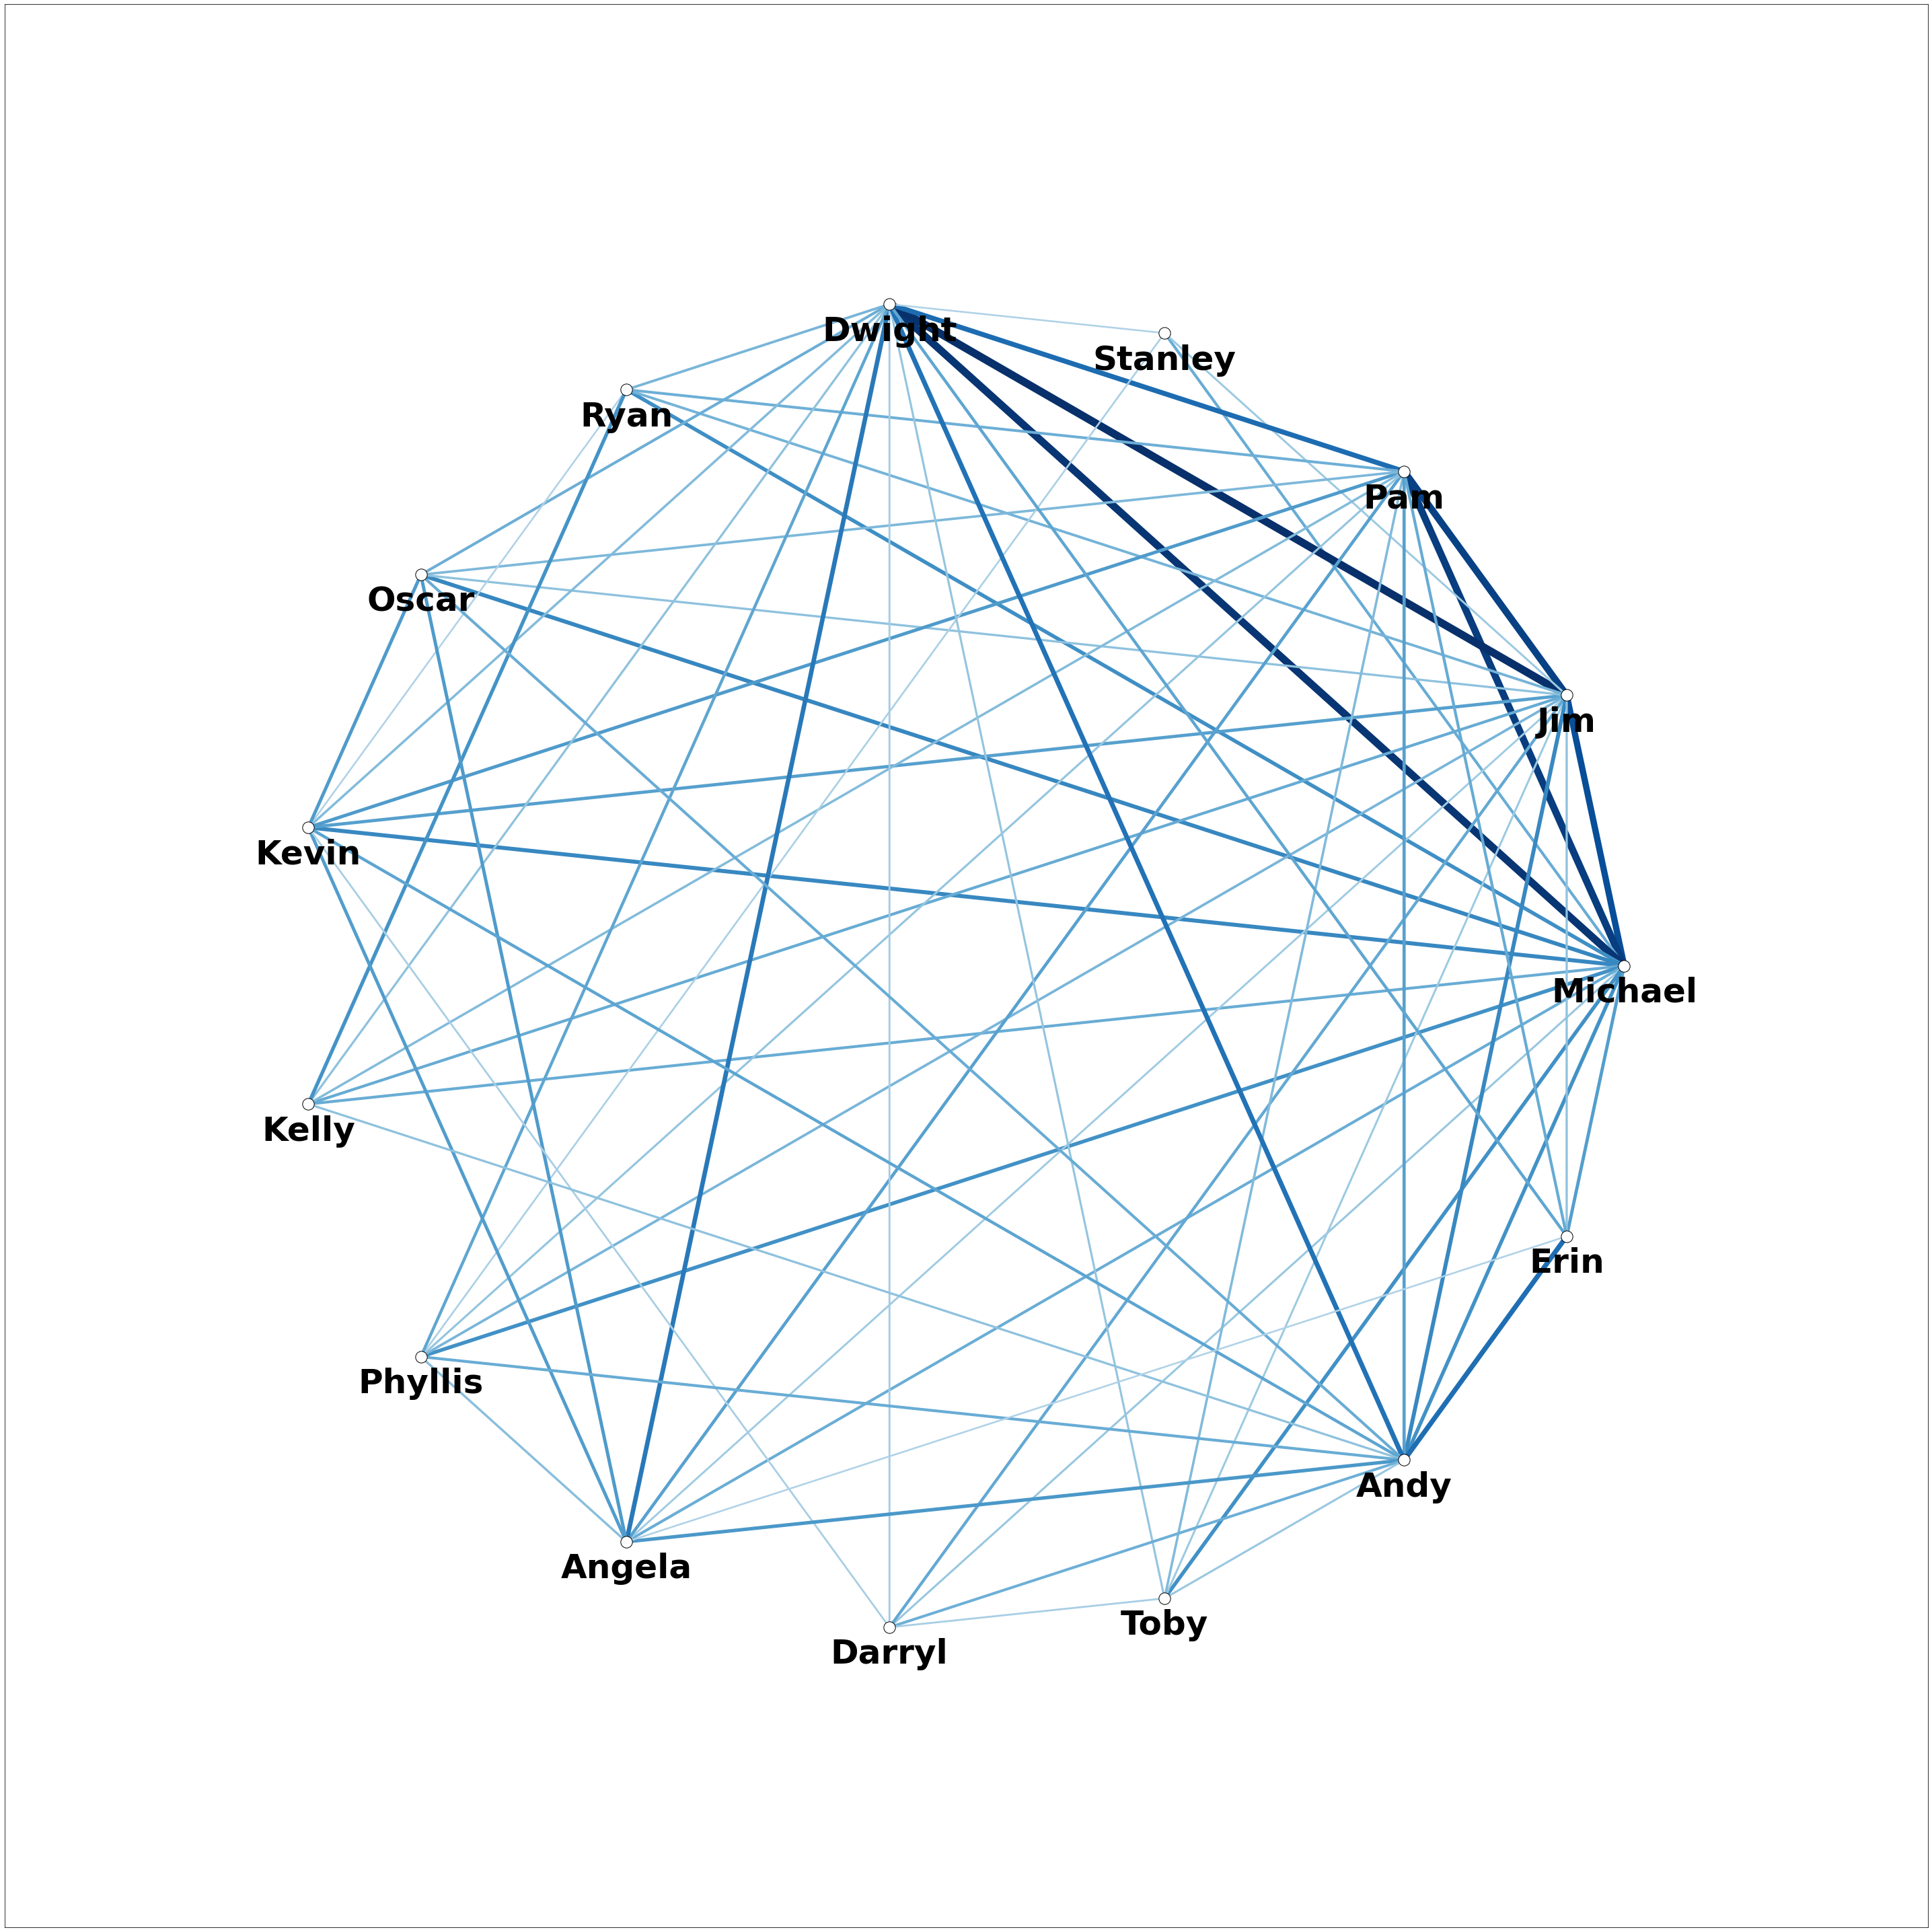

In [94]:

def plot_fig_para(G):
    plt.figure(figsize=(40, 40))
    pos = nx.circular_layout(G)
    
    edges = G.edges()

    colors = [G[u][v]['Weight']**0.1 for u, v in edges]

    weights = [G[u][v]['Weight']**0.4 if G[u][v]['Weight'] > 10 else 0 for u, v in edges]
    

    cmap = matplotlib.cm.get_cmap('Blues')
    nx.draw_networkx(G, pos, width=weights, edge_color=colors,
                     node_color="white", edge_cmap=cmap, with_labels=False)

    labels_pos = {name: [pos_list[0], pos_list[1]-0.04] for name, pos_list in pos.items()}
    nd = nx.draw_networkx_labels(G, labels_pos, font_size=50, font_family="sans-serif",
                            font_color="#000000", font_weight='bold')

    ax = plt.gca()
    ax.collections[0].set_edgecolor('#000000')
    ax.margins(0.25)
    plt.axis("equal")
    plt.tight_layout()

plot_fig_para(G)